# 2021 Student Conference for Global Sustainability
## : Visualization of Global Value Chain Network Graphs

In [2]:
import pandas as pd
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

pd.plotting.register_matplotlib_converters()
sns.set_palette('bright')
matplotlib.rcParams['axes.unicode_minus'] = False
sns.set_style('white')
palette = sns.color_palette("bright")
font_files = fm.findSystemFonts(fontpaths=['/Library/Fonts'])
fm.fontManager.ttflist.extend(fm.createFontList(font_files))
%matplotlib inline

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
import networkx as nx
import win32com.client as win32

## 1. Constructing Network Data

In [36]:
import os

path = 'C:\\Users\\User\\cbam\\data\\'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.xls')]

In [18]:
excel = win32.gencache.EnsureDispatch('Excel.Application')

In [22]:
for x in file_list_py:
    excel = win32.gencache.EnsureDispatch('Excel.Application')
    fname = path+x
    wb = excel.Workbooks.Open(fname)
    wb.SaveAs(fname+"x", FileFormat = 51)
    wb.Close()
    excel.Application.Quit()

In [23]:
excel.Application.Quit()

In [101]:
country = ['BLR', 'BRA', 'CAN', 'CHN', 'EGY', 'IND', 'JPN', 'KOR', 'MYS', 'RUS', 'TUR', 'UAE', 'UKR', 'USA', 'ZAF']
countryl = ['Belarus', 'Brazil', "Canada", 'China', "Egypt", "India", "Japan", 'South Korea', "Malaysia", 'Russia', "Turkey", "UAE", 'Ukraine', 'USA', 'South Africa']

In [39]:
#72
df = ['df_'+ x for x in country]
dfsum = ['dfsum_'+ x for x in country]
for x in range(15):
    df[x] = pd.read_excel(path+file_list_py[x]+"x").tail(30).iloc[:,:12]
    df[x].columns = ['CNcode', 'industry']+df[x].iloc[0,2:12].to_list()
    df[x] = df[x].iloc[1:,:]
    df[x].drop(df[x][df[x]['CNcode'] =='\'7202'].index, inplace = True)
    df[x].drop(df[x][df[x]['CNcode'] =='\'7204'].index, inplace = True)
    dfsum[x] = pd.DataFrame(df[x].sum()).T

In [40]:
#73
df2 = ['df2_'+ x for x in country]
df2sum = ['df2sum_'+ x for x in country]
for x in range(15,30):
    num = x-15
    df2[num] = pd.read_excel(path+file_list_py[x]+"x").tail(27).iloc[:,:12]
    df2[num].columns = ['CNcode', 'industry']+df2[num].iloc[0,2:12].to_list()
    df2[num] = df2[num].iloc[1:,:]
    df2[num] = df2[num][df2[num]['CNcode'].isin(['\'7301','\'7302','\'7303','\'7304','\'7305','\'7306','\'7307','\'7308','\'7309','\'7310','\'7311',])]
    df2sum[num] = pd.DataFrame(df2[num].sum()).T

In [41]:
len(dftotal)

16

In [42]:
#total
dftotal = ['dftotal'+x for x in country]
dfzip = pd.DataFrame()
for x in range(15):
    dftotal[x] = dfsum[x]+df2sum[x]
    dfzip = pd.concat([dfzip, dftotal[x]])

In [44]:
dfzip['country'] = country

In [46]:
df2017 = pd.DataFrame()
df2017['From'] = dfzip['country']
df2017['To'] = 'EU'
df2017['Weight'] = dfzip['Value in 2017']
df2017.index = country

In [48]:
dfsec = pd.read_excel('./data/sectortocountry.xlsx')

In [49]:
dfsecf = dfsec[(dfsec['Unnamed: 3'].str.contains('metal'))&(dfsec["Unnamed: 1"].isin(country))]
dfsecf2 = dfsec[(dfsec['Unnamed: 3'].str.contains('steel'))&(dfsec["Unnamed: 1"].isin(country))]
dfsecf3 = dfsec[(dfsec['Unnamed: 3'].str.contains('iron'))&(dfsec["Unnamed: 1"].isin(country))]

In [243]:
dfsecft = pd.concat([dfsecf, dfsecf2, dfsecf3])
dfsecft = dfsecft[~dfsecft['Unnamed: 3'].str.contains('Non')]
dfsecft = dfsecft[~dfsecft['Unnamed: 3'].str.contains('non')]
dfsecft = dfsecft.set_index("Unnamed: 1")
dfsecft = dfsecft.drop(['Unnamed: 0', "Unnamed: 2", 'Unnamed: 3'], axis =1)
dfsecft = dfsecft.groupby(dfsecft.index).sum()
dfsec2017 = pd.DataFrame(dfsecft.unstack()).reset_index()
dfsec2017.columns = ['From', 'To', 'Weight']
for x in range(15):
    dfsec2017['From'] = dfsec2017['From'].str.replace(countryl[x], country[x])

In [244]:
dfsec2017 = dfsec2017[~(dfsec2017['From']==dfsec2017['To'])]
dfsec2017['Weight'] = dfsec2017['Weight']*0.01
dfsec2017 = dfsec2017[dfsec2017['Weight']>=2000]

In [246]:
dfsec2017 = dfsec2017.set_index(dfsec2017['From'])
dfsec2017s = dfsec2017.append(df2017)

## 2. Network Visualization

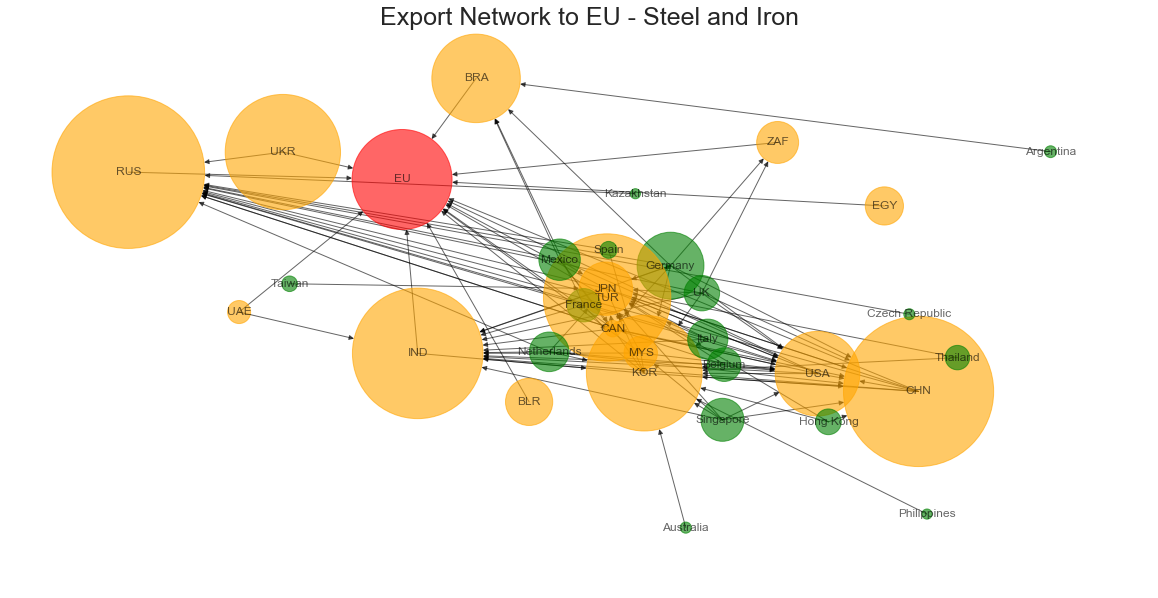

In [265]:
plt.figure(figsize = (20,10))
node_sizes = []
g = nx.from_pandas_edgelist(dfsec2017s, 'From', 'To', create_using = nx.DiGraph())

color_map = []
for node in g:
    if node in country:
        color_map.append('orange')
        node_sizes.append(df2017.loc[node, 'Weight']*0.005)
    elif node == 'EU':
        color_map.append('red')
        node_sizes.append(10000)
    else: 
        color_map.append('green')
        node_sizes.append(dfsec2017.loc[node, 'Weight'].sum()*0.05)
plt.title('Export Network to EU - Steel and Iron', fontsize = 25)
nx.draw(g, node_size = node_sizes, node_color = color_map,  with_labels = True, alpha = 0.6)


In [344]:
# Compute the betweenness centrality of G: bet_cen
bet_cen = nx.betweenness_centrality(g)
sorted(bet_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('USA', 0.020877925223880475),
 ('IND', 0.001490853125965002),
 ('RUS', 0.0014860720970875873),
 ('KOR', 0.0012685352831652312),
 ('JPN', 0.0008741004007785416)]

In [346]:
# Compute the degree centrality of G: deg_cen
deg_cen = nx.degree_centrality(g)
sorted(deg_cen.items(), key=lambda x:x[1], reverse=True)[0:5]


[('USA', 0.7738095238095237),
 ('IND', 0.6547619047619048),
 ('KOR', 0.6547619047619048),
 ('RUS', 0.6428571428571428),
 ('JPN', 0.6071428571428571)]

In [347]:
# Compute the page rank of G: page_rank
page_rank = nx.pagerank(g)
sorted(page_rank.items(), key=lambda x:x[1], reverse=True)[0:5]

[('EU', 0.29492035808419814),
 ('IND', 0.04981695558805188),
 ('RUS', 0.04968338854631758),
 ('KOR', 0.04360608814740684),
 ('USA', 0.04247076829266527)]

In [348]:
# Compute the closeness centrality of G: clos_cen
clos_cen = nx.closeness_centrality(g)
sorted(clos_cen.items(), key=lambda x:x[1], reverse=True)[0:5]

[('IND', 0.6493506493506493),
 ('KOR', 0.6459293394777266),
 ('RUS', 0.6396588486140725),
 ('USA', 0.6190476190476191),
 ('JPN', 0.6001984126984127)]

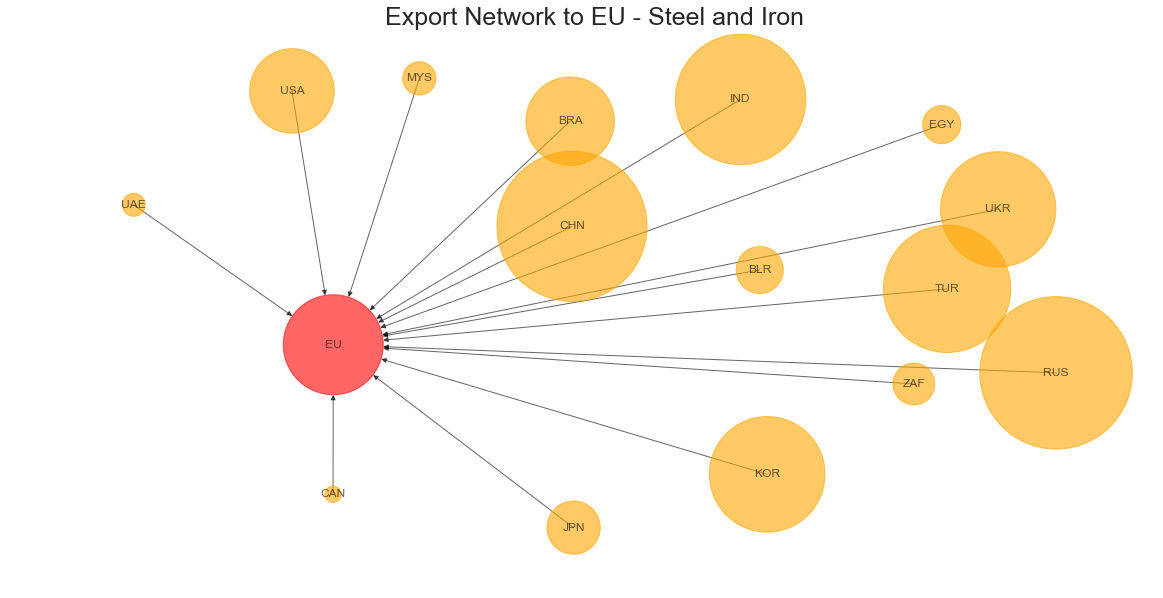

In [180]:
plt.figure(figsize = (20,10))

g2 = nx.from_pandas_edgelist(df2017, 'From', 'To', create_using = nx.DiGraph())
node_sizes = []
color_map = []
for node in g2:
    if node in country:
        color_map.append('orange')
        node_sizes.append(df2017.loc[node, 'Weight']*0.005)
    else:
        color_map.append('red')
        node_sizes.append(10000)
plt.title('Export Network to EU - Steel and Iron', fontsize = 25)
nx.draw(g2, node_size = node_sizes, with_labels = True, node_color = color_map, alpha = 0.6)


In [154]:
wdf = pd.read_excel('./data/weight.xlsx')

In [155]:
wdf = wdf.set_index('Unnamed: 0')

In [159]:
df2017w = pd.merge(df2017, wdf, left_index=True, right_index=True)

In [226]:
df2017w['Weightc'] = df2017w['Weight']*df2017w['CBA']
df2017w['Weightnd'] = df2017w['Weight']/df2017w['ND-GAIN']

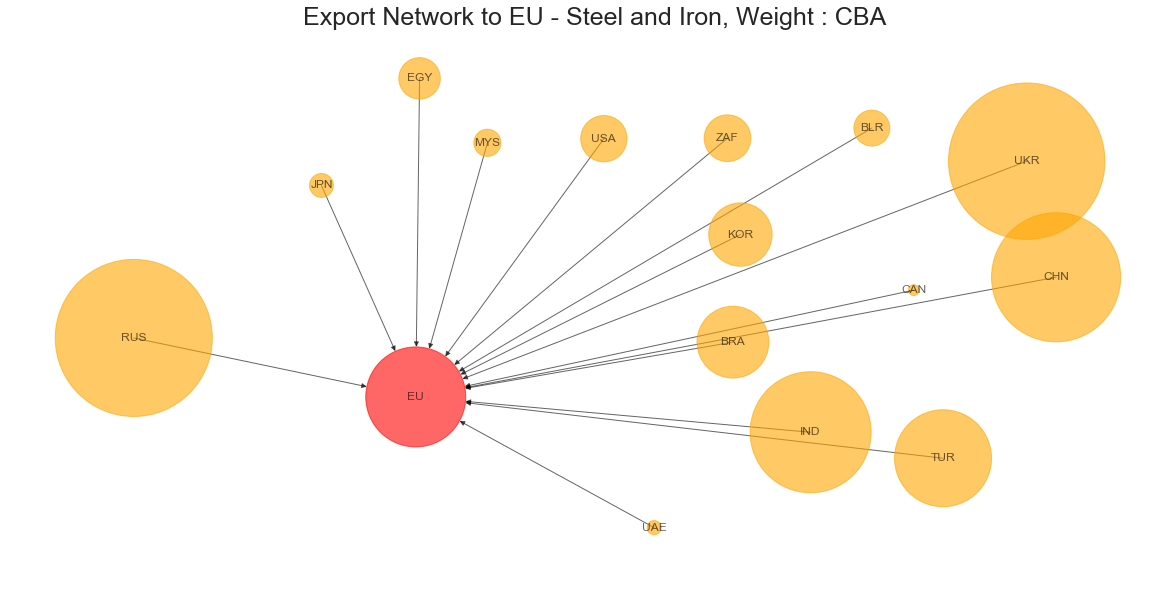

In [225]:
plt.figure(figsize = (20,10))

g3 = nx.from_pandas_edgelist(df2017w, 'From', 'To', create_using = nx.DiGraph())
node_sizes = []
color_map = []
for node in g3:
    if node in country:
        color_map.append('orange')
        node_sizes.append(df2017w.loc[node, 'Weightc']*0.001)
    else:
        color_map.append('red')
        node_sizes.append(10000)
plt.title('Export Network to EU - Steel and Iron, Weight : CBA', fontsize = 25)
nx.draw(g3, node_size = node_sizes, with_labels = True, node_color = color_map, alpha = 0.6)


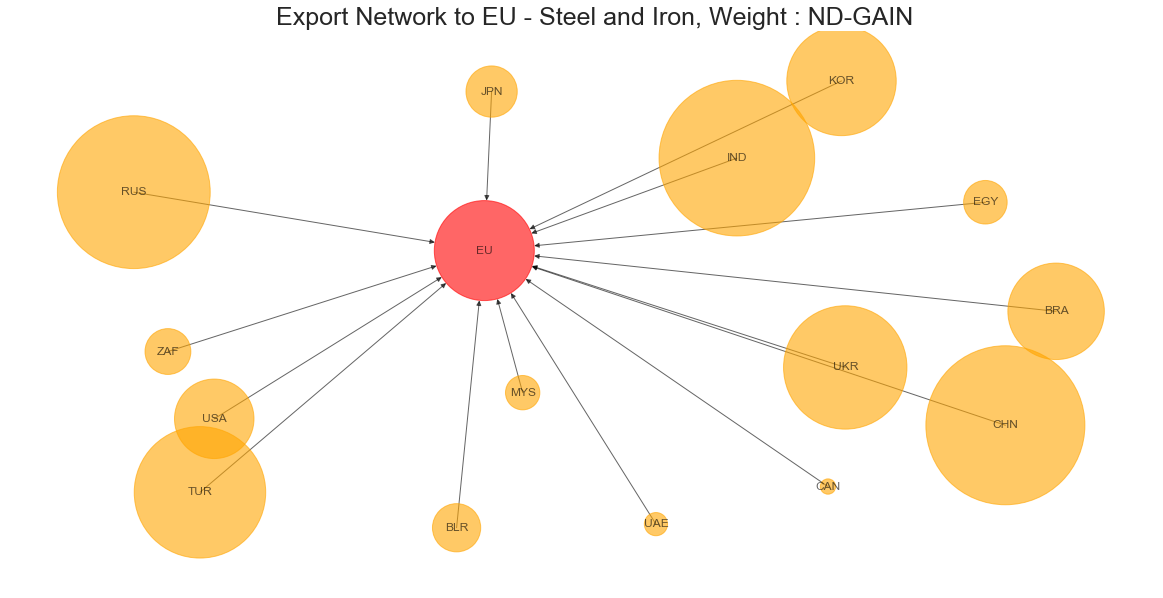

In [242]:
plt.figure(figsize = (20,10))

g4 = nx.from_pandas_edgelist(df2017w, 'From', 'To', create_using = nx.DiGraph())
node_sizes = []
color_map = []
for node in g4:
    if node in country:
        color_map.append('orange')
        node_sizes.append(df2017w.loc[node, 'Weightnd']*0.3)
    else:
        color_map.append('red')
        node_sizes.append(10000)
plt.title('Export Network to EU - Steel and Iron, Weight : ND-GAIN', fontsize = 25)
nx.draw(g4, node_size = node_sizes, with_labels = True, node_color = color_map, alpha = 0.6)


In [291]:
dfgdp = pd.read_excel('./data/gdp.xlsx')
dfgdp.columns = ['Year', 'Series']+country
df2017w[['gdp','gdppercap']] = dfgdp.T.iloc[2:,1:3]
df2017w.to_csv('export_data.csv')
df2017w['weightdiff'] = df2017w['Weightc']-df2017w['Weight']

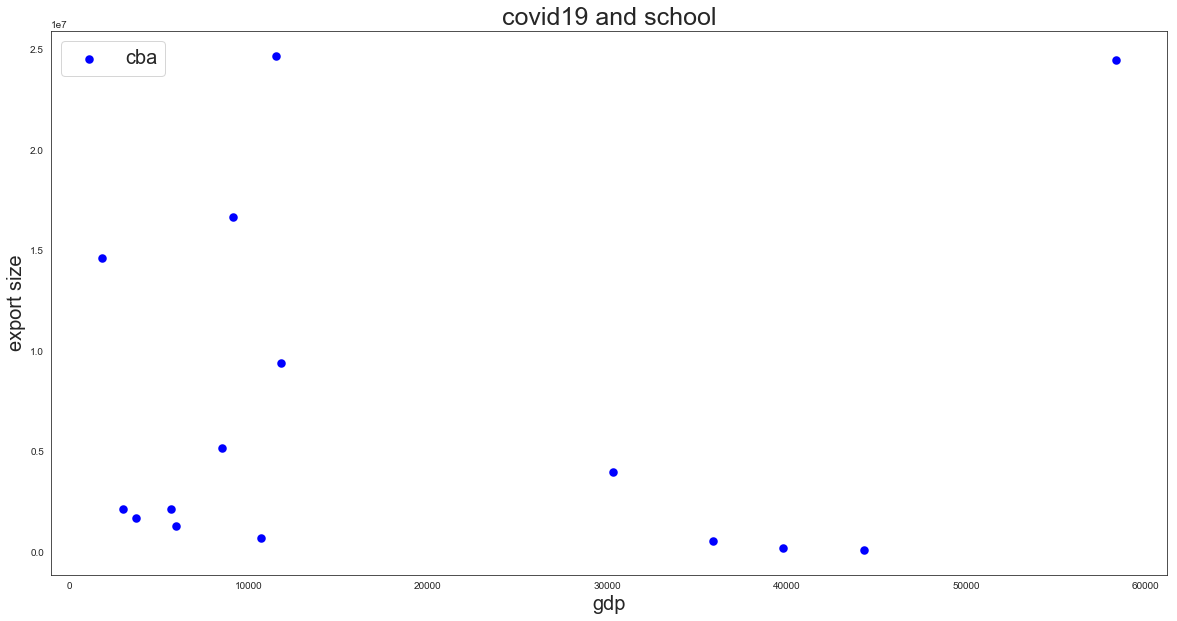

In [286]:
plt.figure(figsize=(20, 10))
# line1 = plt.scatter(df2017w['gdp'], df2017w['Weight'], color= 'k', linewidth = 2.5, label = 'export')
line2 = plt.scatter(df2017w['gdp'], df2017w['Weightc'], color= 'b', linewidth = 2.5, label = 'cba')
plt.legend(loc='upper left', fontsize =20)
plt.title('covid19 and school', fontsize=25)
plt.xlabel('gdp', fontsize=20)
plt.ylabel('export size', fontsize=20)
plt.show()